In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from category_encoders.target_encoder import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree

In [74]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.drop(columns='customerID', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [75]:
def convert_to_numerical(data):
    # Define the mappings
    mappings = {
        'Yes': 1,
        'No': 0,
        'Female': 0,
        'Male': 1,
        'Month-to-month': 0,
        'One year': 1,
        'Two year': 2,
        'Electronic check': 0,
        'Mailed check': 1,
        'Bank transfer (automatic)': 2,
        'Credit card (automatic)': 3,
        'DSL': 0,
        'Fiber optic': 1,
        'No internet service': 2,
        'No phone service': 2
    }

    # Apply the mappings to the relevant columns
    for column in ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']:
        if column in df.columns:
            df[column] = df[column].map(mappings).fillna(df[column])
    
    return df

df = convert_to_numerical(df)

In [76]:

categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

    # Convert categorical columns to 'category' data type
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
df = df.fillna(0)
targetColumn = df['Churn']
otherColumns = df.drop(columns=targetColumn.name)

xTrain, xTest, yTrain, yTest = train_test_split(otherColumns, targetColumn, test_size=0.2, stratify=targetColumn, random_state=1)

XGBoost

In [77]:
estimators = [('encoder', TargetEncoder()),
              ('clf', XGBClassifier(random_state = 1))] #XGBRegressor for regression problem

pipe = Pipeline(steps=estimators)
searchSpace = {
    'clf__max_depth': Integer(2, 6),
    'clf__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample': Real(0.5, 1.0),
    'clf__colsample_bytree': Real(0.5, 1.0),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode': Real(0.5, 1.0),
    'clf__reg_alpha': Real(0.0, 10.0),
    'clf__reg_lambda': Real(0.0, 10.0),
    'clf__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, searchSpace, cv=5, n_iter=20, scoring='roc_auc_ovr', random_state=1, refit=True)
opt.fit(xTrain, yTrain)
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['gender', 'SeniorCitizen', 'Partner',
                                     'Dependents', 'PhoneService',
                                     'MultipleLines', 'InternetService',
                                     'OnlineSecurity', 'OnlineBackup',
                                     'DeviceProtection', 'TechSupport',
                                     'StreamingTV', 'StreamingMovies',
                                     'Contract', 'PaperlessBilling',
                                     'PaymentMethod'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=...
                               gamma=1.4564339539751738, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.03016660392328957, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

0.8390723087654034


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

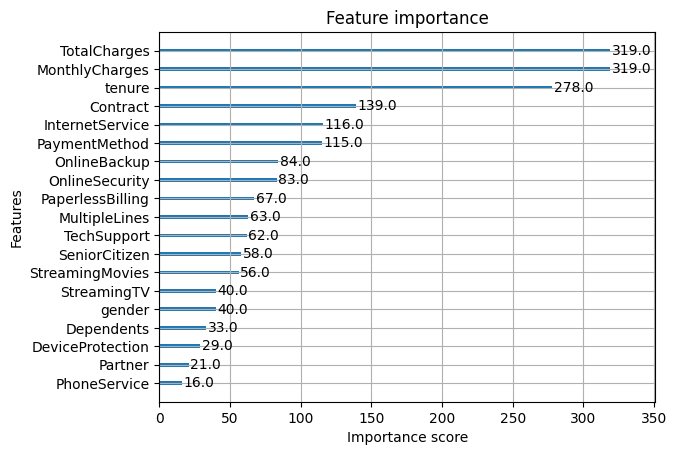

In [97]:
print(opt.score(xTest, yTest))
plot_importance(opt.best_estimator_.steps[1][1])

In [79]:
print(df.head())
rf = RandomForestClassifier(random_state=1)
searchSpace = {
    'max_depth': Integer(3, 6),
    'ccp_alpha': Real(0.0, 10.0),
    'n_estimators': Integer(10, 1000),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(2, 10),
}
rf = BayesSearchCV(estimator=rf, search_spaces=searchSpace, n_iter=20, cv=5, random_state=2)
rf.fit(xTrain, yTrain)

  gender SeniorCitizen Partner Dependents  tenure PhoneService MultipleLines  \
0      0           0.0       1          0       1            0             2   
1      1           0.0       0          0      34            1             0   
2      1           0.0       0          0       2            1             0   
3      1           0.0       0          0      45            0             2   
4      0           0.0       0          0       2            1             0   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0               0              0            1                0           0   
1               0              1            0                1           0   
2               0              1            1                0           0   
3               0              1            0                1           1   
4               1              0            0                0           0   

  StreamingTV StreamingMovies Contract PaperlessBi

BayesSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1), n_iter=20,
              random_state=2,
              search_spaces={'ccp_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=3, high=6, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=10, high=1000, prior='uniform', transform='normalize')})

0.7991483321504613


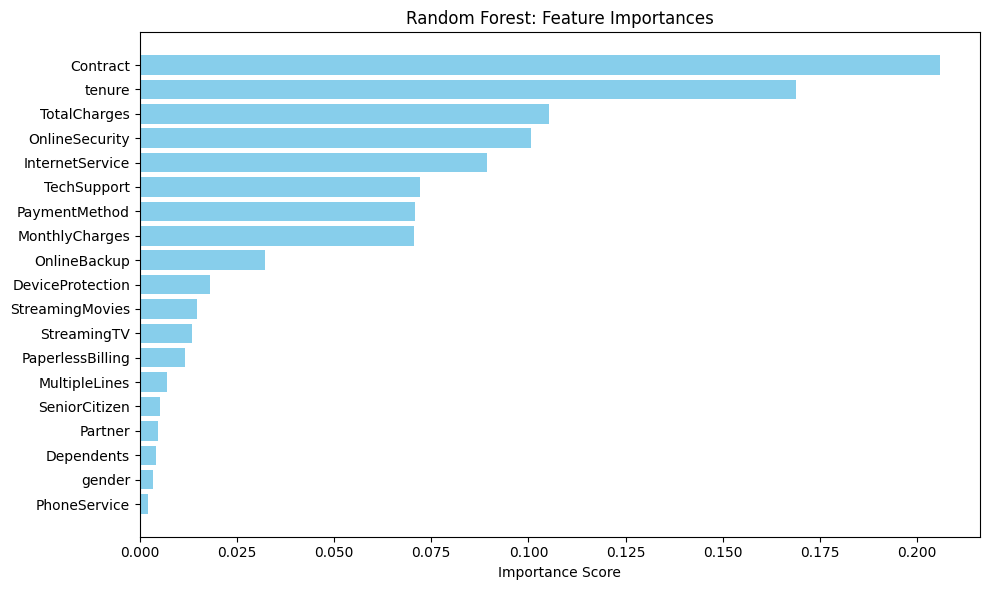

In [98]:
import matplotlib.pyplot as plt
print(rf.score(xTest, yTest))
best_rf_model = rf.best_estimator_  

importances = best_rf_model.feature_importances_
feature_names = xTrain.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Random Forest: Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [81]:
lr = LogisticRegression(max_iter=2000)
lr.fit(xTrain, yTrain)
lr.score(xTest, yTest)

0.8097941802696949

             Feature  Importance
7    InternetService    0.877487
14          Contract    0.748319
8     OnlineSecurity    0.418209
15  PaperlessBilling    0.345424
11       TechSupport    0.289774
13   StreamingMovies    0.264956
6      MultipleLines    0.255617
9       OnlineBackup    0.243127
1      SeniorCitizen    0.213990
12       StreamingTV    0.204939
16     PaymentMethod    0.163585
3         Dependents    0.088024
4             tenure    0.062525
2            Partner    0.038510
0             gender    0.038328
5       PhoneService    0.020447
10  DeviceProtection    0.013974
17    MonthlyCharges    0.003946
18      TotalCharges    0.000375


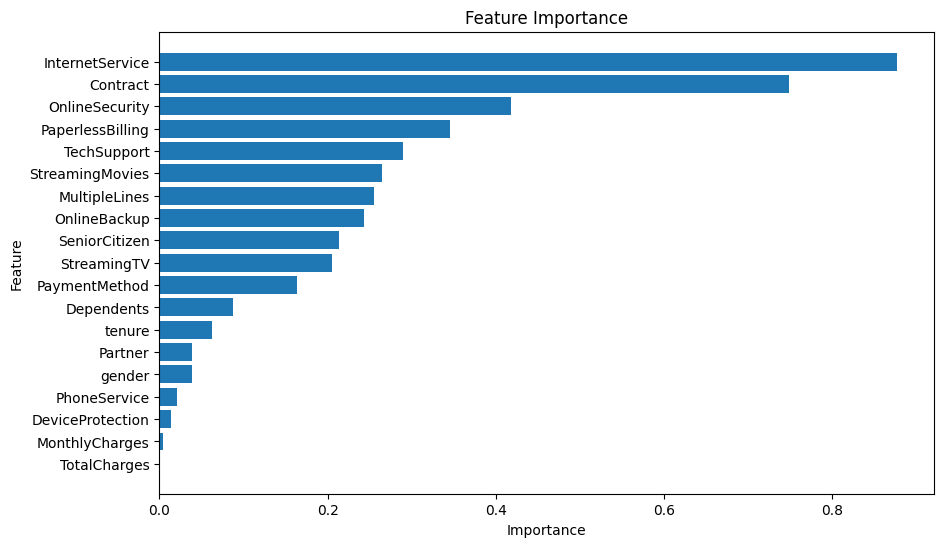

In [92]:
# Get the coefficients of the model
coef = abs(lr.coef_[0])

# Create a DataFrame to hold feature names and their importance
feature_importance = pd.DataFrame({
    'Feature': xTrain.columns,
    'Importance': coef
})

# Sort the DataFrame by importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()



In [111]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-8,
                    hidden_layer_sizes=(5, 2), random_state=1, max_iter = 2000)

clf.fit(xTrain, yTrain)
clf.score(xTest, yTest)

0.808374733853797

             Feature  Importance
4             tenure    0.081416
17    MonthlyCharges    0.031878
14          Contract    0.017998
8     OnlineSecurity    0.014022
11       TechSupport    0.008750
6      MultipleLines    0.007597
15  PaperlessBilling    0.005769
9       OnlineBackup    0.005360
18      TotalCharges    0.004544
16     PaymentMethod    0.003106
10  DeviceProtection    0.001065
2            Partner    0.000941
0             gender    0.000923
1      SeniorCitizen    0.000905
7    InternetService    0.000870
12       StreamingTV    0.000657
13   StreamingMovies    0.000231
3         Dependents    0.000195
5       PhoneService    0.000124


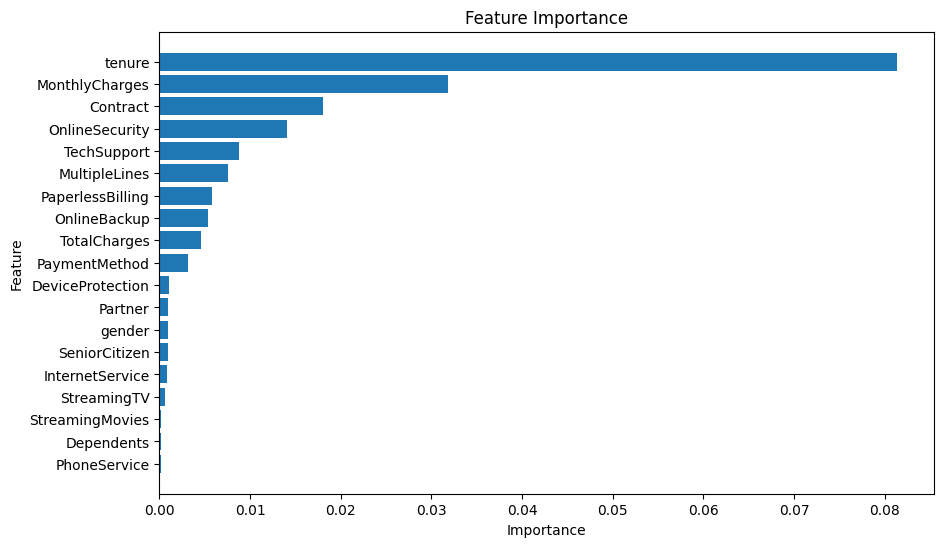

In [101]:

from sklearn.inspection import permutation_importance

# Calculate permutation feature importance
result = permutation_importance(clf, xTrain, yTrain, n_repeats=10, random_state=1, n_jobs=-1)

# Get the importance values
importance = abs(result.importances_mean)

# Create a DataFrame to hold feature names and their importance
feature_importance = pd.DataFrame({
    'Feature': xTrain.columns,
    'Importance': importance
})

# Sort the DataFrame by importance in descending order
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()
